Import Libraries

In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing import image
from keras.layers import Rescaling, Input
import time
from PIL import Image, ImageDraw
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split
)
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense

In [2]:
base_dir = r"C:\Users\chang\MyJava\concerete_crack_images-3-1 (1)\concerete_crack_images\training"

In [14]:
test = r"C:\Users\chang\MyJava\concerete_crack_images-3-1 (1)\concerete_crack_images\test"

In [15]:
# Function to get a random sample of images from the dataset
def get_random_sample_images(base_dir, sample_size=100):
    images = []
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        image_files = os.listdir(subdir_path)
        # Randomly select images from each class
        selected_files = random.sample(image_files, min(sample_size // 2, len(image_files)))
        for image_name in selected_files:
            image_path = os.path.join(subdir_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
    return images

# Class balance check
def check_class_balance(base_dir):
    classes = os.listdir(base_dir)
    counts = {cls: len(os.listdir(os.path.join(base_dir, cls))) for cls in classes}
    return counts

def read_images(base_dir):
    images = []
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        for image_name in os.listdir(subdir_path):
            image_path = os.path.join(subdir_path, image_name)
            image = cv2.imread(image_path)
            images.append(image)
    return images

# Image size distribution
def check_image_size_distribution(images):
    sizes = [image.shape[:2] for image in images]
    return sizes

# Pixel intensity analysis
def analyze_pixel_intensity(images):
    intensities = [image.flatten() for image in images]
    return np.concatenate(intensities)

# Color space analysis
def analyze_color_space(images):
    hsv_values = {'hue': [], 'saturation': [], 'value': []}
    for image in images:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)
        hsv_values['hue'].extend(h.flatten())
        hsv_values['saturation'].extend(s.flatten())
        hsv_values['value'].extend(v.flatten())
    return hsv_values

In [4]:
images = read_images(base_dir)
class_balance = check_class_balance(base_dir)
print("Class Balance:", class_balance)

Class Balance: {'Negative': 16037, 'Positive': 16070}


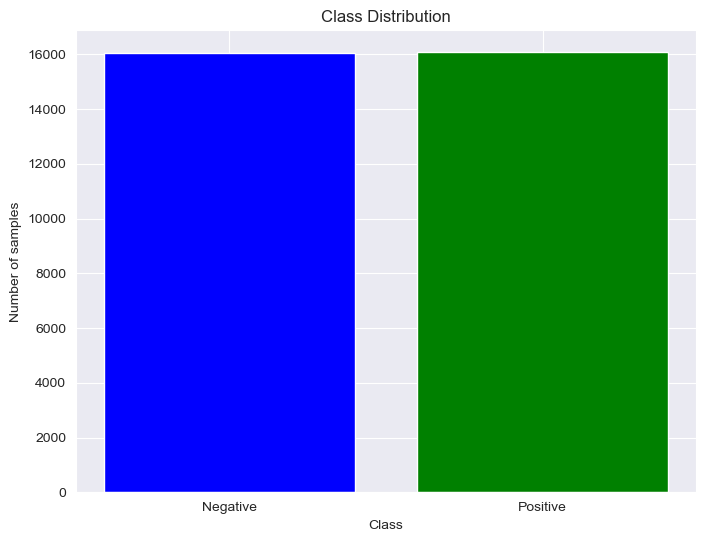

In [32]:
class_balance = {'Negative': 16037, 'Positive': 16070}

# Names of the classes
classes = list(class_balance.keys())
# Counts of each class
counts = list(class_balance.values())

# Creating the bar plot
plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color=['blue', 'green'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.show()

In [20]:
images_test_sample = []
# Randomly select images from the provided list of file paths
all_files = [f for f in os.listdir(test) if os.path.isfile(os.path.join(test, f))]

selected_files = random.sample(all_files, min(100, len(all_files)))
for image_name in selected_files:
    image_path = os.path.join(test, image_name)
    image_test_sample = cv2.imread(image_path)
    if image_test_sample is not None:
        images_test_sample.append(image_test_sample)

In [21]:
# random_images = get_random_sample_images(base_dir, sample_size=100)
size_distribution = check_image_size_distribution(images_test_sample)
intensities = analyze_pixel_intensity(images_test_sample)
hsv_values = analyze_color_space(images_test_sample)

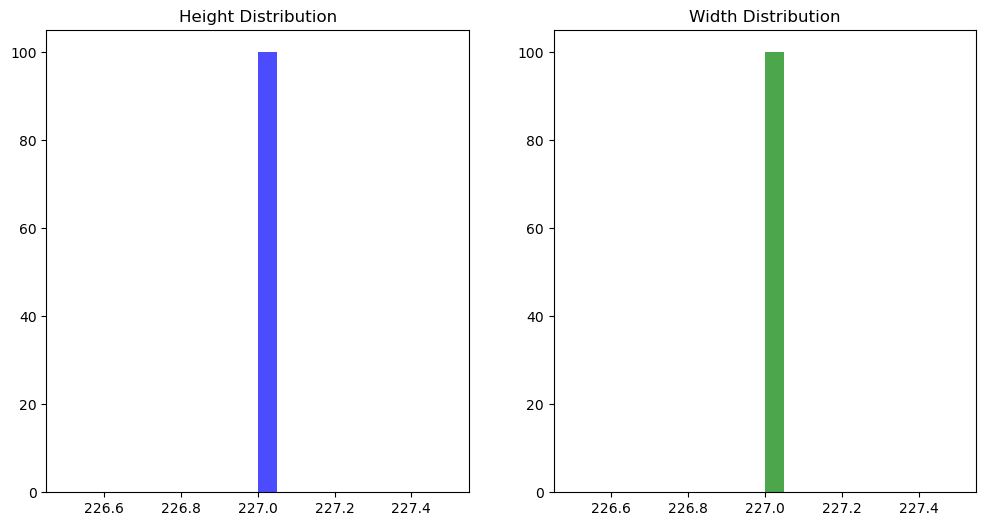

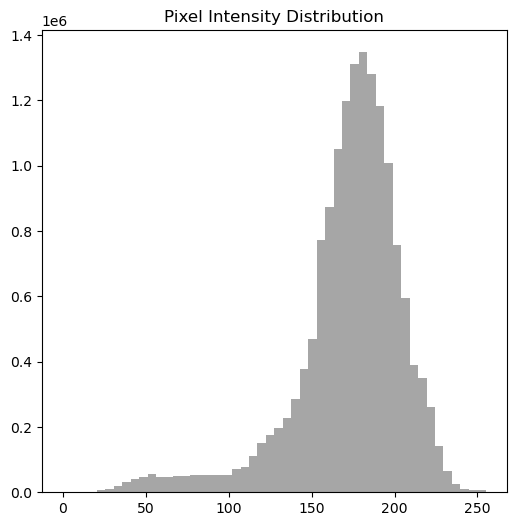

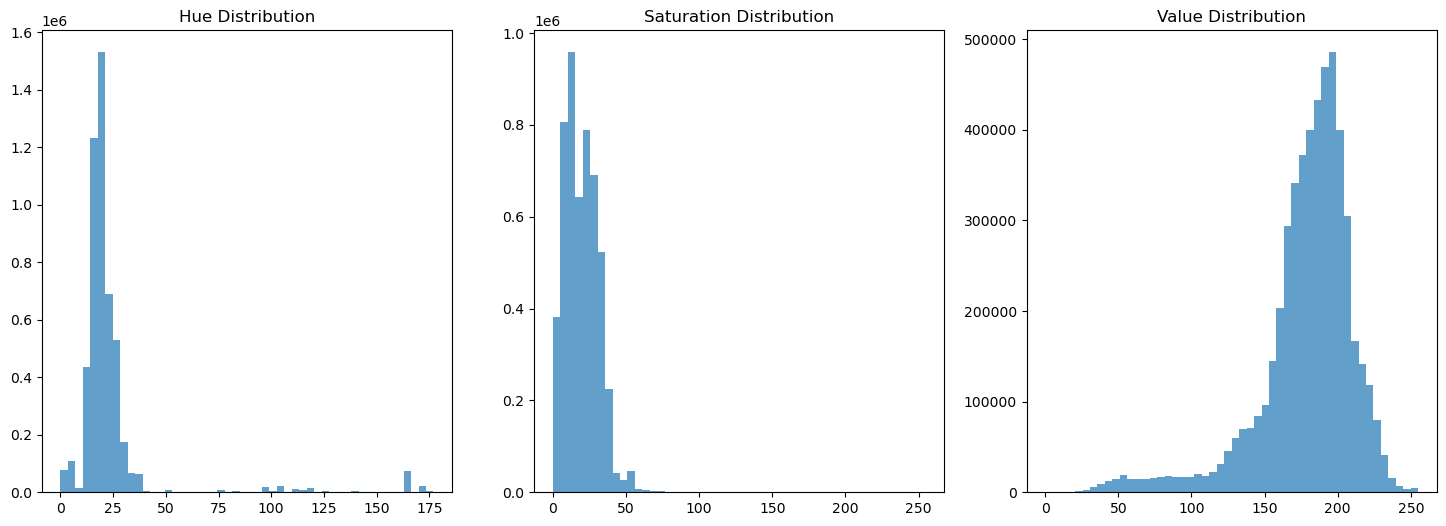

In [22]:
# Plotting size distribution
heights, widths = zip(*size_distribution)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(heights, bins=20, color='blue', alpha=0.7)
plt.title('Height Distribution')
plt.subplot(1, 2, 2)
plt.hist(widths, bins=20, color='green', alpha=0.7)
plt.title('Width Distribution')
plt.show()

# Plot pixel intensity distribution
plt.figure(figsize=(6, 6))
plt.hist(intensities, bins=50, color='gray', alpha=0.7)
plt.title('Pixel Intensity Distribution')
plt.show()

# Plot HSV color space distribution
plt.figure(figsize=(18, 6))
for i, (color_component, values) in enumerate(hsv_values.items()):
    plt.subplot(1, 3, i+1)
    plt.hist(values, bins=50, alpha=0.7)
    plt.title(f'{color_component.capitalize()} Distribution')
plt.show()

In [4]:
log_dir = os.path.join("logs", "fit", time.strftime("%Y-%m-%d_%H-%M-%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

Filter out corrupted images

In [4]:
num_skipped = 0

for folder_name in ("Positive", "Negative"):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


Generate a Dataset

In [6]:
image_size = (64, 64)
batch_size = 128

train_ds = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

Found 32107 files belonging to 2 classes.
Using 25686 files for training.
Found 32107 files belonging to 2 classes.
Using 6421 files for validation.


Visualize the data

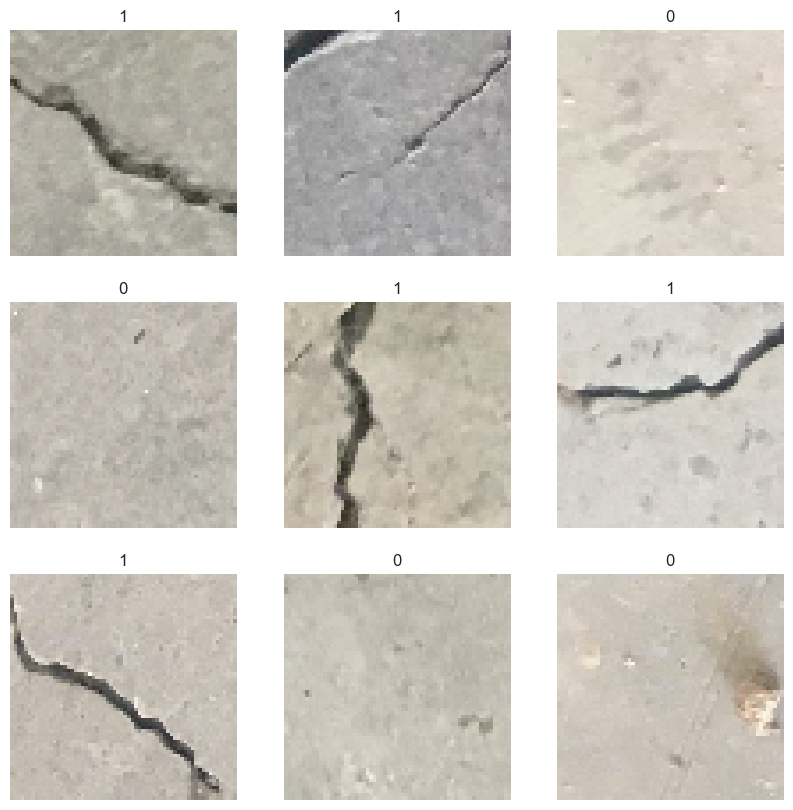

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(128, 64, 64, 3)
(128,)


Preprocess the data

Using image data augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.Rescaling(1.0 / 255),
    layers.RandomZoom(0.1, 0.1, fill_mode='nearest')
])

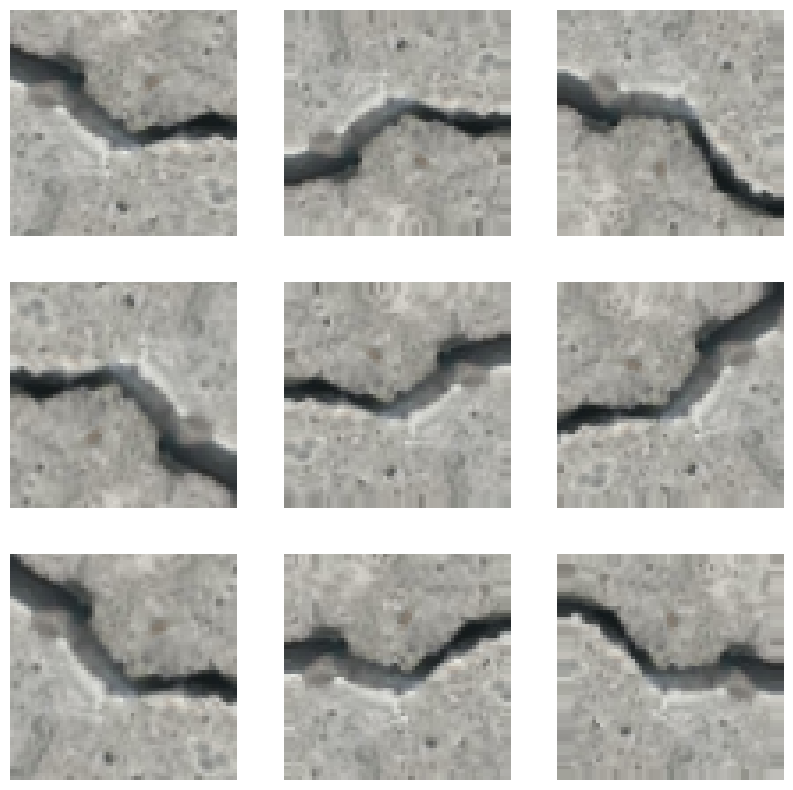

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0].numpy() * 255).astype('uint8'))
        plt.axis("off")

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

# Use data augmentation on training data
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img, training=True), label),
    num_parallel_calls=AUTOTUNE,
)

# Use rescaling on validation data
val_ds = val_ds.map(
    lambda img, label: (layers.Rescaling(1.0 / 255)(img), label),
    num_parallel_calls=AUTOTUNE,
)

# Help maximize GPU utilization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create a model

In [5]:
model0 = Sequential([
    Input(shape=(64, 64, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model0.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
               metrics=['accuracy'])

epochs=10

history0 = model0.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
201/201 [==============================] - 21s 96ms/step - loss: 8.2840 - accuracy: 0.9135 - val_loss: 0.0931 - val_accuracy: 0.9822
Epoch 2/10
201/201 [==============================] - 5s 25ms/step - loss: 0.0712 - accuracy: 0.9830 - val_loss: 0.0494 - val_accuracy: 0.9846
Epoch 3/10
201/201 [==============================] - 6s 27ms/step - loss: 0.0534 - accuracy: 0.9867 - val_loss: 0.0420 - val_accuracy: 0.9874
Epoch 4/10
201/201 [==============================] - 6s 28ms/step - loss: 0.0363 - accuracy: 0.9897 - val_loss: 0.0382 - val_accuracy: 0.9899
Epoch 5/10
201/201 [==============================] - 6s 28ms/step - loss: 0.0298 - accuracy: 0.9914 - val_loss: 0.0370 - val_accuracy: 0.9905
Epoch 6/10
201/201 [==============================] - 6s 27ms/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 0.0358 - val_accuracy: 0.9914
Epoch 7/10
201/201 [==============================] - 6s 28ms/step - loss: 0.0216 - accuracy: 0.9940 - val_loss: 0.0390 - val_accuracy: 0.991

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    shuffle=True,
    image_size=(64, 64),
    batch_size=batch_size)

def dataset_to_numpy(dataset):
    all_images = []
    all_labels = []
    
    for images, labels in dataset:
        normalized_images = images.numpy() / 255.0
        all_images.append(normalized_images)
        all_labels.append(labels.numpy())
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_images, all_labels

images, labels = dataset_to_numpy(dataset)

# Stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_per_fold = []

# Loop through folds
for train_index, test_index in skf.split(images, labels):
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(128)
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(128)
    
    history0 = model0.fit(train_ds, epochs=10, validation_data=test_ds)
    
    scores = model0.evaluate(test_ds)
    acc_per_fold.append(scores[1])      
    
average_accuracy = np.mean(acc_per_fold)
print(f'Average accuracy across all folds: {average_accuracy * 100:.4f}%')

Found 32107 files belonging to 2 classes.
Epoch 1/10
201/201 [==============================] - 2s 11ms/step - loss: 0.2572 - accuracy: 0.9321 - val_loss: 0.0815 - val_accuracy: 0.9706
Epoch 2/10
201/201 [==============================] - 2s 9ms/step - loss: 0.0641 - accuracy: 0.9807 - val_loss: 0.0472 - val_accuracy: 0.9849
Epoch 3/10
201/201 [==============================] - 2s 9ms/step - loss: 0.0466 - accuracy: 0.9850 - val_loss: 0.0440 - val_accuracy: 0.9849
Epoch 4/10
201/201 [==============================] - 2s 9ms/step - loss: 0.0396 - accuracy: 0.9876 - val_loss: 0.0404 - val_accuracy: 0.9855
Epoch 5/10
201/201 [==============================] - 2s 8ms/step - loss: 0.0358 - accuracy: 0.9886 - val_loss: 0.0384 - val_accuracy: 0.9865
Epoch 6/10
201/201 [==============================] - 2s 8ms/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0364 - val_accuracy: 0.9868
Epoch 7/10
201/201 [==============================] - 2s 9ms/step - loss: 0.0310 - accuracy: 0.9900 - val

In [7]:
img_height = 64
img_width = 64
num_classes = 2

model1 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # Set to False for sigmoid activation
               metrics=['accuracy'])

In [8]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)        

Train the model

In [11]:
epochs=10

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=tensorboard_callback
)

Epoch 1/10
201/201 [==============================] - 36s 133ms/step - loss: 0.2055 - accuracy: 0.9177 - val_loss: 0.2972 - val_accuracy: 0.9363
Epoch 2/10
201/201 [==============================] - 23s 117ms/step - loss: 0.0592 - accuracy: 0.9829 - val_loss: 0.0523 - val_accuracy: 0.9882
Epoch 3/10
201/201 [==============================] - 23s 115ms/step - loss: 0.0483 - accuracy: 0.9861 - val_loss: 0.0377 - val_accuracy: 0.9899
Epoch 4/10
201/201 [==============================] - 23s 116ms/step - loss: 0.0401 - accuracy: 0.9887 - val_loss: 0.0310 - val_accuracy: 0.9910
Epoch 5/10
201/201 [==============================] - 23s 115ms/step - loss: 0.0347 - accuracy: 0.9897 - val_loss: 0.1015 - val_accuracy: 0.9737
Epoch 6/10
201/201 [==============================] - 23s 116ms/step - loss: 0.0315 - accuracy: 0.9908 - val_loss: 0.0477 - val_accuracy: 0.9860
Epoch 7/10
201/201 [==============================] - 23s 115ms/step - loss: 0.0253 - accuracy: 0.9928 - val_loss: 0.0175 - val_ac

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

Reusing TensorBoard on port 6006 (pid 20572), started 1 day, 0:17:13 ago. (Use '!kill 20572' to kill it.)

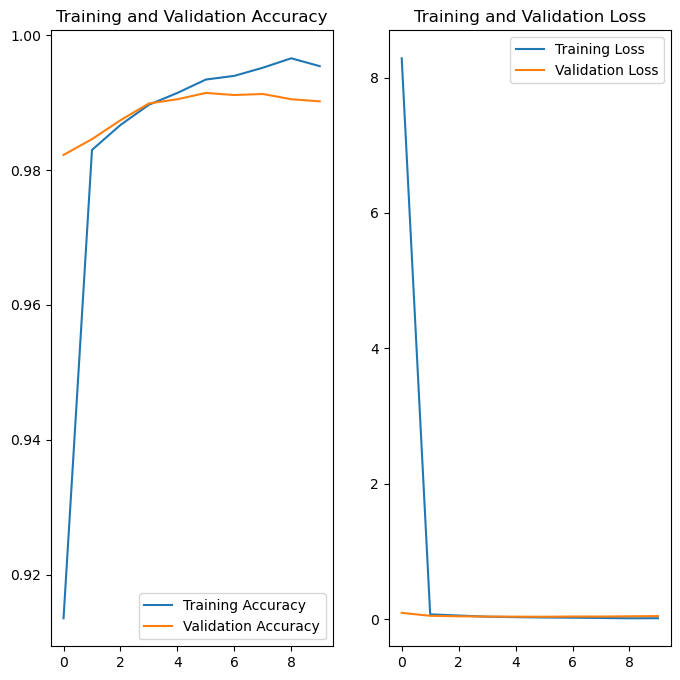

In [6]:
acc = history0.history['accuracy']
val_acc = history0.history['val_accuracy']

loss = history0.history['loss']
val_loss = history0.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Add dropout and batch normalization

In [21]:
model2 = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  
               metrics=['accuracy'])

epochs = 15
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback]
)

Epoch 1/15
201/201 [==============================] - 41s 174ms/step - loss: 0.0789 - accuracy: 0.9780 - val_loss: 7.6252 - val_accuracy: 0.4957
Epoch 2/15
201/201 [==============================] - 34s 167ms/step - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0887 - val_accuracy: 0.9807
Epoch 3/15
201/201 [==============================] - 34s 169ms/step - loss: 0.0185 - accuracy: 0.9944 - val_loss: 0.0192 - val_accuracy: 0.9944
Epoch 4/15
201/201 [==============================] - 35s 172ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0103 - val_accuracy: 0.9974
Epoch 5/15
201/201 [==============================] - 34s 172ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 0.0135 - val_accuracy: 0.9955
Epoch 6/15
201/201 [==============================] - 34s 171ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.1080 - val_accuracy: 0.9673
Epoch 7/15
201/201 [==============================] - 34s 170ms/step - loss: 0.0085 - accuracy: 0.9977 - val_loss: 0.1453 - val_ac

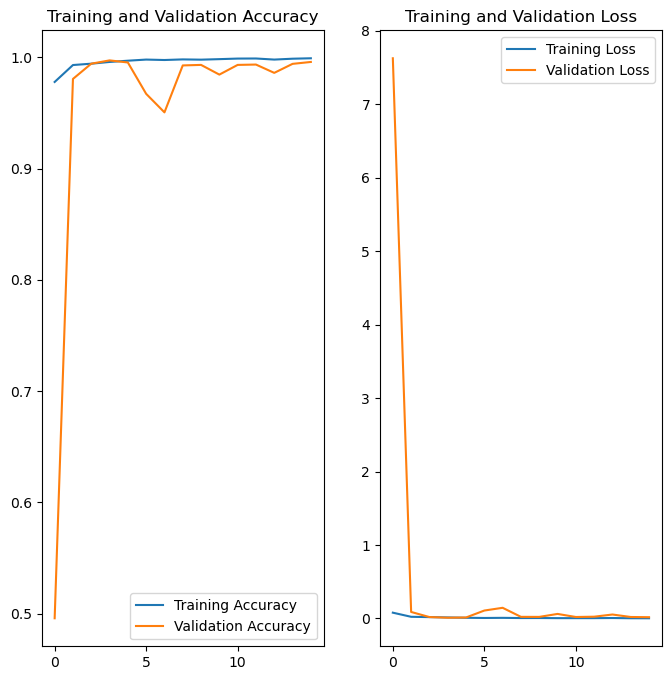

In [22]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Add callbacks

In [23]:
model3 = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  
               metrics=['accuracy'])

callbacks3 = [
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]

history3 = model3.fit(
        train_ds,
        validation_data=val_ds,
        epochs=25,
        callbacks=[callbacks3, tensorboard_callback]
    )

Epoch 1/25
201/201 [==============================] - 34s 166ms/step - loss: 0.0711 - accuracy: 0.9782 - val_loss: 8.8146 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 2/25
201/201 [==============================] - 33s 163ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.0539 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 3/25
201/201 [==============================] - 32s 161ms/step - loss: 0.0168 - accuracy: 0.9953 - val_loss: 0.0371 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 4/25
201/201 [==============================] - 33s 162ms/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.1077 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 5/25
201/201 [==============================] - 32s 161ms/step - loss: 0.0129 - accuracy: 0.9961 - val_loss: 0.7425 - val_accuracy: 0.8819 - lr: 0.0010
Epoch 6/25
201/201 [==============================] - 33s 162ms/step - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.1018 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 7/25
201/201 [==============================] 

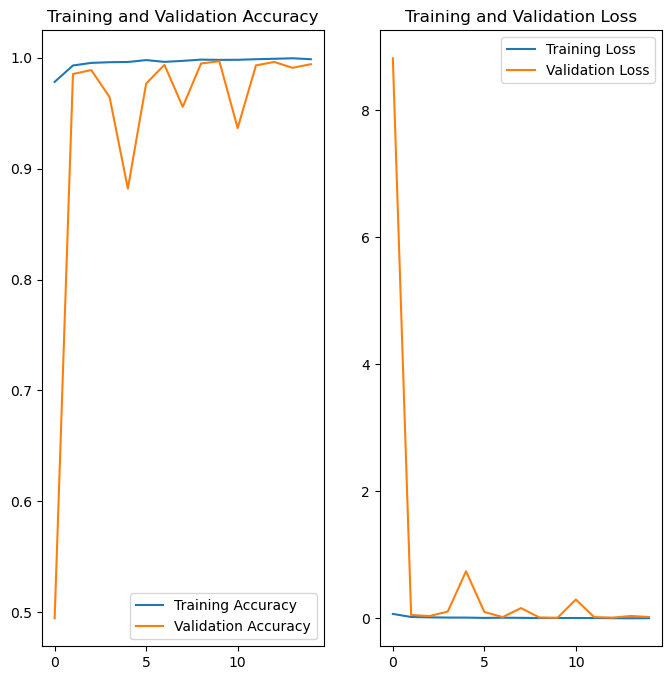

In [24]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Adjust data augmentation

In [36]:
data_augmentation2 = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Rescaling(1.0 / 255),
    layers.RandomZoom(0.2, 0.2, fill_mode='nearest')
])

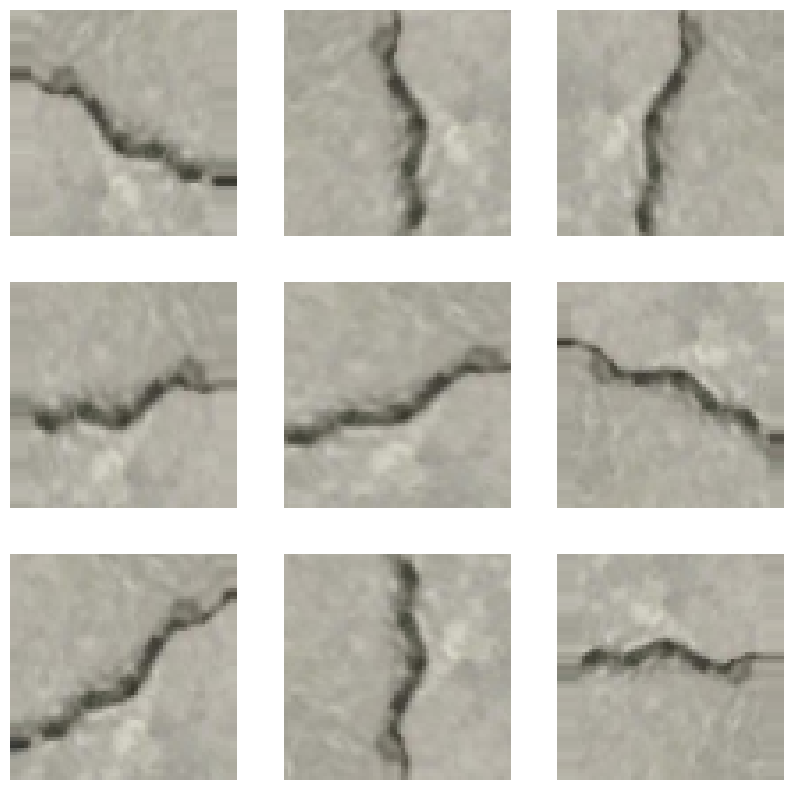

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation2(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0].numpy() * 255).astype('uint8'))
        plt.axis("off")

In [37]:
AUTOTUNE = tf.data.AUTOTUNE

# Use new data augmentation on training data
train_ds2 = train_ds.map(
    lambda img, label: (data_augmentation2(img, training=True), label),
    num_parallel_calls=AUTOTUNE,
)

# Use rescaling on validation data
val_ds2 = val_ds.map(
    lambda img, label: (layers.Rescaling(1.0 / 255)(img), label),
    num_parallel_calls=AUTOTUNE,
)

# Help maximize GPU utilization
train_ds2 = train_ds2.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds2 = val_ds2.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
model4 = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model4.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  
               metrics=['accuracy'])

callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
        tensorboard_callback
    ]

history4 = model4.fit(
        train_ds2,
        validation_data=val_ds2,
        epochs=25,
        callbacks=callbacks
    )

Epoch 1/25
201/201 [==============================] - 40s 167ms/step - loss: 0.0791 - accuracy: 0.9784 - val_loss: 6.8024 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 2/25
201/201 [==============================] - 32s 161ms/step - loss: 0.0246 - accuracy: 0.9922 - val_loss: 0.2322 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 3/25
201/201 [==============================] - 33s 162ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0881 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 4/25
201/201 [==============================] - 33s 164ms/step - loss: 0.0138 - accuracy: 0.9961 - val_loss: 0.0509 - val_accuracy: 0.9866 - lr: 0.0010
Epoch 5/25
201/201 [==============================] - 32s 160ms/step - loss: 0.0150 - accuracy: 0.9955 - val_loss: 0.0080 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 6/25
201/201 [==============================] - 32s 162ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.0389 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 7/25
201/201 [==============================] 

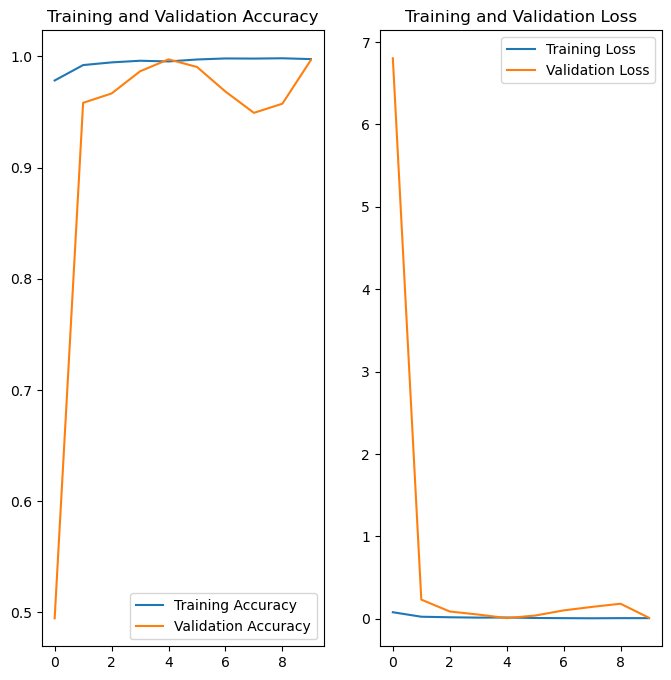

In [33]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Adjust to more complex model (add layers)

In [38]:
model5 = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),  
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),  
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(256, activation='relu'), 
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
])

model5.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  
               metrics=['accuracy'])

callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
    ]

history5 = model5.fit(
    train_ds2,
    validation_data=val_ds2,
    epochs=30,
    callbacks=[callbacks, tensorboard_callback]
)

Epoch 1/30
201/201 [==============================] - 51s 218ms/step - loss: 0.0443 - accuracy: 0.9860 - val_loss: 4.5475 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 2/30
201/201 [==============================] - 41s 205ms/step - loss: 0.0182 - accuracy: 0.9944 - val_loss: 1.2228 - val_accuracy: 0.7619 - lr: 0.0010
Epoch 3/30
201/201 [==============================] - 41s 202ms/step - loss: 0.0156 - accuracy: 0.9958 - val_loss: 0.0081 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 4/30
201/201 [==============================] - 41s 203ms/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 0.0267 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/30
201/201 [==============================] - 40s 201ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.0195 - val_accuracy: 0.9942 - lr: 0.0010
Epoch 6/30
201/201 [==============================] - 41s 204ms/step - loss: 0.0093 - accuracy: 0.9972 - val_loss: 0.0341 - val_accuracy: 0.9911 - lr: 0.0010
Epoch 7/30
201/201 [==============================] 

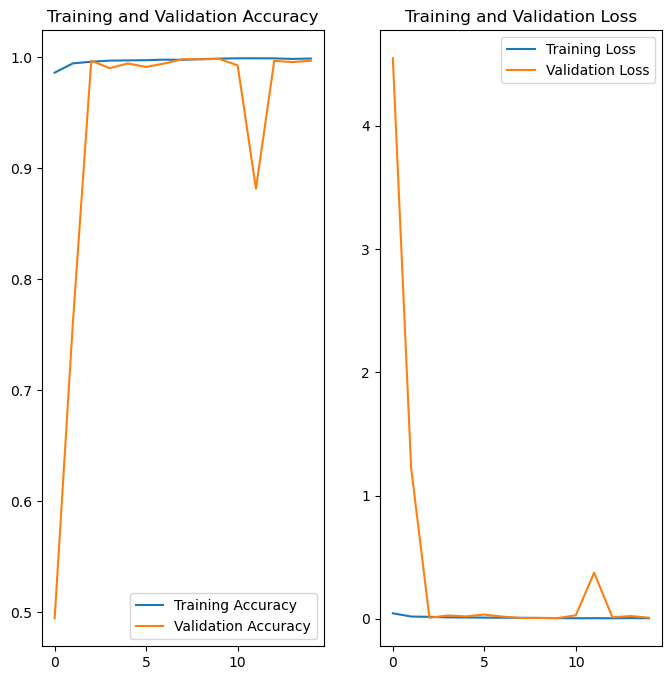

In [39]:
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

147/147 [==============================] - 2s 16ms/step


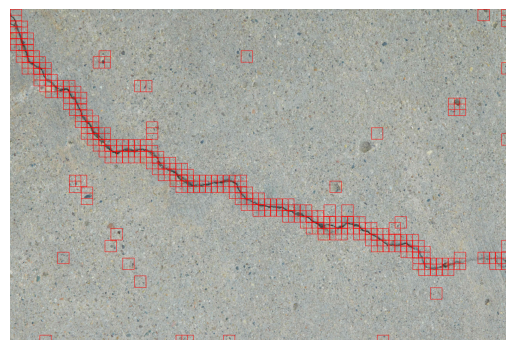

In [13]:
def slide_and_predict(image, model, window_size=128, step_size=64, threshold=0.5):
    img_width, img_height = image.size
    patches = []
    coordinates = []

    for y in range(0, img_height, step_size):
        for x in range(0, img_width, step_size):
            box = (x, y, min(x + window_size, img_width), min(y + window_size, img_height))
            patch = image.crop(box)
            patch = patch.convert("RGB")
            patch = np.array(patch.resize((64, 64))) / 255.0  # Resize and normalize
            patches.append(patch)
            coordinates.append((x, y))

    patches = np.array(patches)

    # Get predictions
    predictions = model.predict(patches)
    predicted_classes = (predictions.flatten() >= threshold).astype(int)  
    
    return predicted_classes, coordinates

def add_red_outline(image, predicted_classes, coordinates, window_size=128):
    draw = ImageDraw.Draw(image, "RGBA")
    
    for i, (x, y) in enumerate(coordinates):
        if predicted_classes[i] == 1:  
            draw.rectangle([x, y, x+window_size, y+window_size], outline="red", width=5)  
    
    # print("Detected crack coordinates:", [(coord, pred) for coord, pred in zip(coordinates, predicted_classes) if pred == 1])
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
image_path = r'C:\Users\chang\OneDrive\NEU\6105\Final term\test2.jpg'
image = Image.open(image_path).convert("RGBA")

# model = tf.keras.models.load_model(f'model_best_fold2.h5')
predicted_classes, coordinates = slide_and_predict(image, model7, threshold=0.5)

add_red_outline(image, predicted_classes, coordinates)

Adjust data augmentation

In [7]:
data_augmentation3 = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.Rescaling(1.0 / 255),
    layers.RandomZoom(0.1, 0.1, fill_mode='nearest')
])

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# Use new data augmentation on training data
train_ds3 = train_ds.map(
    lambda img, label: (data_augmentation3(img, training=True), label),
    num_parallel_calls=AUTOTUNE,
)

# Use rescaling on validation data
val_ds3 = val_ds.map(
    lambda img, label: (layers.Rescaling(1.0 / 255)(img), label),
    num_parallel_calls=AUTOTUNE,
)

# Help maximize GPU utilization
train_ds3 = train_ds3.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds3 = val_ds3.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
model7 = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),  
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),  
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(256, activation='relu'), 
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
])

model7.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  
               metrics=['accuracy'])

callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
        tensorboard_callback
    ]

history7 = model7.fit(
    train_ds3,
    validation_data=val_ds3,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
201/201 [==============================] - 47s 202ms/step - loss: 0.0462 - accuracy: 0.9849 - val_loss: 5.8458 - val_accuracy: 0.4946 - lr: 0.0010
Epoch 2/30
201/201 [==============================] - 38s 188ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.6271 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 3/30
201/201 [==============================] - 39s 192ms/step - loss: 0.0135 - accuracy: 0.9962 - val_loss: 0.0305 - val_accuracy: 0.9879 - lr: 0.0010
Epoch 4/30
201/201 [==============================] - 38s 189ms/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 0.0282 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 5/30
201/201 [==============================] - 37s 186ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.0142 - val_accuracy: 0.9952 - lr: 0.0010
Epoch 6/30
201/201 [==============================] - 38s 187ms/step - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.0148 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 7/30
201/201 [==============================] 

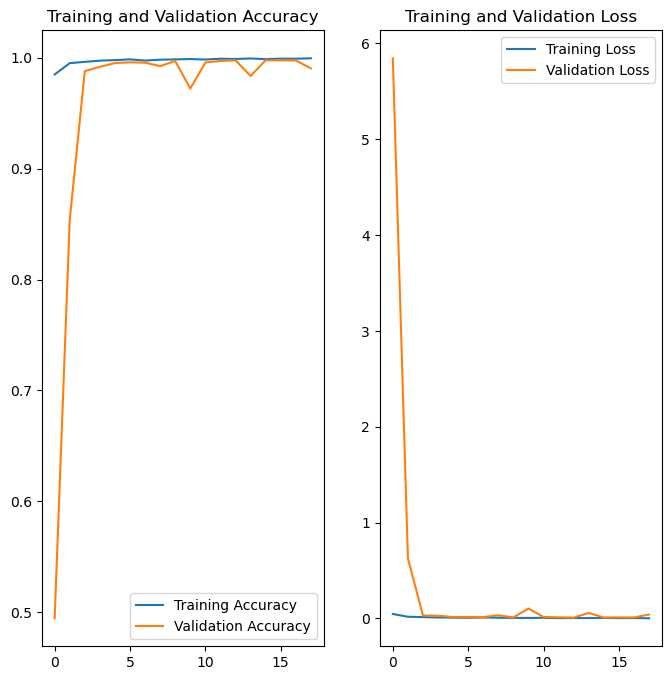

In [10]:
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Try the model on the crack photos not in this dataset

12/12 [==============================] - 0s 14ms/step


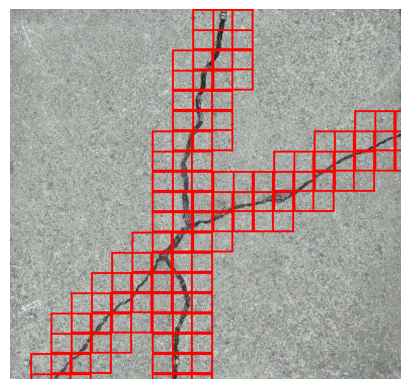

In [11]:
def slide_and_predict(image, model, window_size=64, step_size=32, threshold=0.5):
    img_width, img_height = image.size
    patches = []
    coordinates = []

    for y in range(0, img_height, step_size):
        for x in range(0, img_width, step_size):
            box = (x, y, min(x + window_size, img_width), min(y + window_size, img_height))
            patch = image.crop(box)
            patch = patch.convert("RGB")
            patch = np.array(patch.resize((64, 64))) / 255.0  # Resize and normalize
            patches.append(patch)
            coordinates.append((x, y))

    patches = np.array(patches)

    # Get predictions
    predictions = model.predict(patches)
    predicted_classes = (predictions.flatten() >= threshold).astype(int)  
    
    return predicted_classes, coordinates

def add_red_outline(image, predicted_classes, coordinates, window_size=64):
    draw = ImageDraw.Draw(image, "RGBA")
    
    for i, (x, y) in enumerate(coordinates):
        if predicted_classes[i] == 1:  
            draw.rectangle([x, y, x+window_size, y+window_size], outline="red", width=3)  
    
    # print("Detected crack coordinates:", [(coord, pred) for coord, pred in zip(coordinates, predicted_classes) if pred == 1])
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
image_path = r'C:\Users\chang\OneDrive\NEU\6105\Final term\test.jpg'
image = Image.open(image_path).convert("RGBA")

# model = tf.keras.models.load_model(f'model_best_fold2.h5')
predicted_classes, coordinates = slide_and_predict(image, model7, threshold=0.5)

add_red_outline(image, predicted_classes, coordinates)

Tensorflow Tuner

In [5]:
image_size = (128, 128)
batch_size = 128
num_classes = 2

train_ds6 = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds6 = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=0,
    image_size=image_size,
    batch_size=batch_size,
)

Found 32107 files belonging to 2 classes.
Using 25686 files for training.
Found 32107 files belonging to 2 classes.
Using 6421 files for validation.


In [39]:
data_augmentation5 = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1, 0.1, fill_mode='nearest'),
    layers.RandomContrast(0.2),  
    layers.Rescaling(1.0 / 255), 
])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

# Use data augmentation on training data
train_ds6 = train_ds6.map(
    lambda img, label: (data_augmentation5(img, training=True), label),
    num_parallel_calls=AUTOTUNE,
)

# Use rescaling on validation data
val_ds6 = val_ds6.map(
    lambda img, label: (layers.Rescaling(1.0 / 255)(img), label),
    num_parallel_calls=AUTOTUNE,
)

# Help maximize GPU utilization
train_ds6 = train_ds6.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds6 = val_ds6.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
def model_builder6(hp):
    model = tf.keras.Sequential()
    num_conv_layers = hp.Int('num_conv_layers', 3, 5, default=3) 
    for i in range(num_conv_layers):
        model.add(layers.Conv2D(hp.Int(f'filters_{i}', 16, 256, step=16, default=16*(2**i)),
                                (3, 3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D())

    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1, default=0.3)))
    model.add(layers.Flatten())

    model.add(layers.Dense(hp.Int('dense_units', 128, 512, step=32, default=256), activation='relu',
                           kernel_regularizer=regularizers.l2(hp.Choice('regularizer_l2', [0.01, 0.001, 0.0001]))))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1, default=0.3)))
    
    model.add(layers.Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4], default=1e-3) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    return model

def make_callbacks6():
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
    ]

# Setup Keras Tuner
tuner = kt.Hyperband(model_builder6,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_advanced')

# Start hyperparameter search
tuner.search(train_ds6, validation_data=val_ds6, epochs=30, callbacks=make_callbacks6())

# Get the best model
best_model6 = tuner.get_best_models(num_models=1)[0]

Trial 53 Complete [02h 21m 23s]
val_accuracy: 0.9900327324867249

Best val_accuracy So Far: 0.9990655779838562
Total elapsed time: 2d 03h 23m 54s


In [8]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for param in best_hps.values:
    print(f'{param}: {best_hps.get(param)}')

num_conv_layers: 5
filters_0: 112
filters_1: 144
filters_2: 192
dropout_1: 0.2
dense_units: 128
regularizer_l2: 0.0001
dropout_2: 0.30000000000000004
learning_rate: 0.01
filters_3: 240
filters_4: 32
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


In [12]:
best_model6.save('best_model6.h5')

In [11]:
loss, accuracy = best_model6.evaluate(val_ds6)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

51/51 [==============================] - 45s 870ms/step - loss: 0.0114 - accuracy: 0.9991
Loss: 0.011434930376708508
Accuracy: 0.9990655779838562


In [21]:
b_model6 = tf.keras.models.load_model(f'best_model6.h5')

In [19]:
# Directory with test images
test_dir = r"C:\Users\chang\MyJava\concerete_crack_images-3-1 (1)\concerete_crack_images\test"

# Function to predict cracks
def predict_cracks(model, directory):
    results = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = image.load_img(img_path, target_size=(128, 128))
        img_tensor = image.img_to_array(img)
        img_tensor = tf.expand_dims(img_tensor, 0)  
        img_tensor /= 255.  

        prediction = model.predict(img_tensor)[0][0]
        
        # Since the output is a probability, we'll consider >0.5 as Positive, otherwise Negative
        label = "Positive" if prediction > 0.5 else "Negative"
        results.append((img_name, label))

    return results

# Predict cracks in the test directory
predictions = predict_cracks(b_model6, test_dir)

# Convert predictions to DataFrame and save as CSV
df_predictions = pd.DataFrame(predictions, columns=['Image Name', 'Prediction'])
csv_path = 'crack_predictions.csv' 
df_predictions.to_csv(csv_path, index=False)

df_predictions.head()  # Displaying the top rows of the dataframe

1/1 [==============================] - 0s 47ms/step


,Image Name,Prediction
0,1000016480768558.png,Positive
1,1000094138882661.png,Negative
2,100010347143101.png,Negative
3,1000228345963509.png,Positive
4,10002760868742.png,Positive


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices([], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("GPUs have been disabled.")
    except RuntimeError as e:
        print(e)

GPUs have been disabled.


Cross Validation just to ensure that the model performs consistently across different subsets of data.

In [4]:
data_dir_net = r"C:\Users\chang\MyJava\concerete_crack_images-3-1 (1)\concerete_crack_images\training"
# "C:/Users/chang/Downloads/concrete_cracked_images/concrete_cracked_images/train"
batch_size = 32
img_height = 128  
img_width = 128   

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_net,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 32107 files belonging to 2 classes.


In [5]:
def dataset_to_numpy(dataset):
    all_images = []
    all_labels = []
    
    for images, labels in dataset:
        normalized_images = images.numpy() / 255.0
        all_images.append(normalized_images)
        all_labels.append(labels.numpy())
    
    all_images = np.concatenate(all_images, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_images, all_labels

images, labels = dataset_to_numpy(dataset)

In [8]:
b_model6 = tf.keras.models.load_model(f'best_model6.h5')

In [7]:
# Stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_per_fold = []

# Loop through folds
for train_index, test_index in skf.split(images, labels):
    train_images, test_images = images[train_index], images[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

    scores = b_model6.evaluate(test_ds)
    acc_per_fold.append(scores[1]) 
    
    
average_accuracy = np.mean(acc_per_fold)
print(f'Average accuracy across all folds: {average_accuracy * 100:.4f}%')

201/201 [==============================] - 46s 223ms/step - loss: 0.0178 - accuracy: 0.9972
Average accuracy across all folds: 99.8225%


147/147 [==============================] - 2s 13ms/step


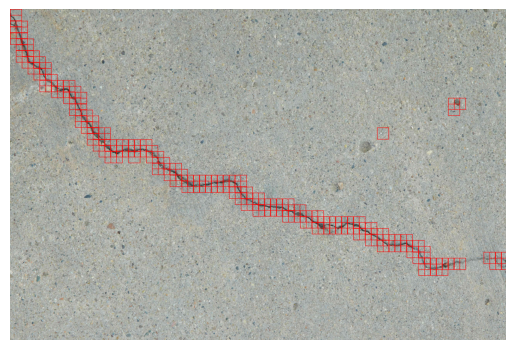

In [9]:
def slide_and_predict(image, model, window_size=128, step_size=64, threshold=0.5):
    img_width, img_height = image.size
    patches = []
    coordinates = []

    for y in range(0, img_height, step_size):
        for x in range(0, img_width, step_size):
            box = (x, y, min(x + window_size, img_width), min(y + window_size, img_height))
            patch = image.crop(box)
            patch = patch.convert("RGB")
            patch = np.array(patch.resize((128, 128))) / 255.0  # Resize and normalize
            patches.append(patch)
            coordinates.append((x, y))

    patches = np.array(patches)

    # Get predictions
    predictions = model.predict(patches)
    predicted_classes = (predictions.flatten() >= threshold).astype(int)  
    
    return predicted_classes, coordinates

def add_red_outline(image, predicted_classes, coordinates, window_size=128):
    draw = ImageDraw.Draw(image, "RGBA")
    
    for i, (x, y) in enumerate(coordinates):
        if predicted_classes[i] == 1:  
            draw.rectangle([x, y, x+window_size, y+window_size], outline="red", width=5)  
    
    # print("Detected crack coordinates:", [(coord, pred) for coord, pred in zip(coordinates, predicted_classes) if pred == 1])
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
image_path = r'C:\Users\chang\OneDrive\NEU\6105\Final term\test2.jpg'
image = Image.open(image_path).convert("RGBA")

# model = tf.keras.models.load_model(f'model_best_fold2.h5')
predicted_classes, coordinates = slide_and_predict(image, b_model6, threshold=0.5)

add_red_outline(image, predicted_classes, coordinates)

In [13]:
b_model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 112)     3136      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 112)    448       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 112)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 144)       145296    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 144)      576       
 hNormalization)                                                 
                                                        

VGG16

In [3]:
image_size16 = (224, 224)
batch_size16 = 64

train_ds16,val_ds16 = image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=image_size16,
    batch_size=batch_size16,
    label_mode='binary'  
)

Found 32107 files belonging to 2 classes.
Using 25686 files for training.
Using 6421 files for validation.


In [4]:
base_model = VGG16(input_shape=image_size16 + (3,), include_top=False, weights='imagenet')

base_model.trainable = False

model16 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid') 
])

model16.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 10
history16 = model16.fit(train_ds16, validation_data=val_ds16, epochs=epochs)

Epoch 1/10
402/402 [==============================] - 83s 200ms/step - loss: 0.1251 - accuracy: 0.9897 - val_loss: 0.0352 - val_accuracy: 0.9960
Epoch 2/10
402/402 [==============================] - 78s 194ms/step - loss: 0.0084 - accuracy: 0.9985 - val_loss: 0.0416 - val_accuracy: 0.9960
Epoch 3/10
402/402 [==============================] - 78s 194ms/step - loss: 7.6103e-04 - accuracy: 0.9996 - val_loss: 0.0595 - val_accuracy: 0.9955
Epoch 4/10
402/402 [==============================] - 79s 197ms/step - loss: 5.0452e-04 - accuracy: 0.9999 - val_loss: 0.0905 - val_accuracy: 0.9950
Epoch 5/10
402/402 [==============================] - 79s 195ms/step - loss: 0.0391 - accuracy: 0.9965 - val_loss: 0.1095 - val_accuracy: 0.9952
Epoch 6/10
402/402 [==============================] - 78s 194ms/step - loss: 0.0165 - accuracy: 0.9979 - val_loss: 0.0945 - val_accuracy: 0.9960
Epoch 7/10
402/402 [==============================] - 78s 194ms/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 0.0884 

In [15]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# Directory with test images
test_dir = r"C:\Users\chang\MyJava\concerete_crack_images-3-1 (1)\concerete_crack_images\test"

# Function to predict cracks
results = []
for img_name in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_name)
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)  
    prediction = model16.predict(img_array)  
    results.append([img_name, prediction[0][0]])  

# Convert predictions to DataFrame and save as CSV
results_df = pd.DataFrame(results, columns=['Image Name', 'Prediction'])
results_df.to_csv('crack_predictions_VGG16.csv', index=False)

results_df.head()  # Displaying the top rows of the dataframe

1/1 [==============================] - 0s 31ms/step


,Image Name,Prediction
0,1000016480768558.png,1.000000e+00
1,1000094138882661.png,2.462763e-03
2,100010347143101.png,3.528596e-10
3,1000228345963509.png,1.000000e+00
4,10002760868742.png,1.000000e+00


In [18]:
model16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


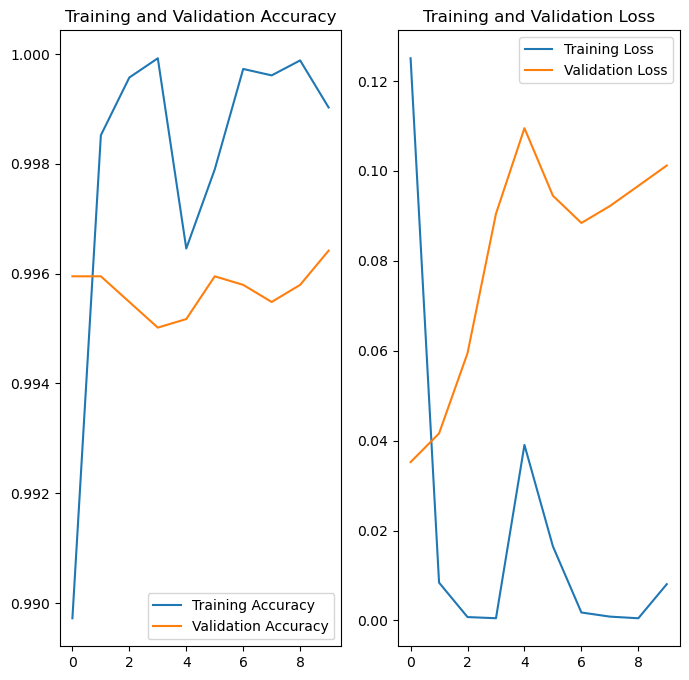

In [5]:
acc = history16.history['accuracy']
val_acc = history16.history['val_accuracy']
loss = history16.history['loss']
val_loss = history16.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()